# Credit Account Default Status and Characteristics

Data source: https://www.kaggle.com/datasets/mishra5001/credit-card?datasetId=263888&select=columns_description.csv

Credit history matters a lot when individuals want to take out loans ... say more about this later

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
original_df = pd.read_csv('data/application_data.csv')

In [3]:
original_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Cleaning

In [4]:
sorted_null = original_df.isnull().mean().sort_values(ascending=False)
sorted_null.index[(sorted_null>0.5)]

Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE',
       'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE',
       'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE'],
      dtype='object')

We observe that all the above columns contains more than X%(50% in our case) of nulls values, and here we make one of our major assumptions in this EDA that these data are simply unknown and can introduce bias which can affect our analysis(as opposed to them being actually informative and shows something in our data). Future work might involve taking a deeper look into these columns, but for now with this assumption in mind, we will drop these columns together with some additional columns like ID number, which we expect to be not useful in our analysis:

In [5]:
# drop columns with more then 50% missing values + additional ones decided by the group
drop_col = ['SK_ID_CURR',]
df = original_df[sorted_null.index[(sorted_null<0.5)]].drop(drop_col, axis=1)
df.columns

Index(['FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE',
       'OCCUPATION_TYPE', 'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
       'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS',
       'DAYS_LAST_PHONE_CHANGE', 'CNT_CHILDREN', 'FLAG_DOCUMENT_8',
       'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_10', 'FLAG_D

## EDA

In the following parts of our analysis, we will identify some interesting findings in our data and attempt to build a logistic regression model to predict whether a customer will default or not. But for now, let us explore the different variables in our datasets.

First, we look at the general picture of what is the proportion of people using credit cards who are able to pay on time vs those who failed to pay on time

In [8]:
print("proportion of people who paid on time:", 1-df["TARGET"].mean())
print("proportion of people who failed to pay on time:", df["TARGET"].mean())

proportion of people who paid on time: 0.9192711805431351
proportion of people who failed to pay on time: 0.08072881945686496


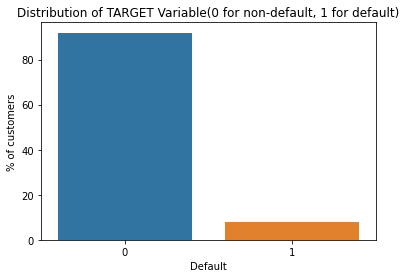

In [17]:
sns.barplot(x="TARGET", y="TARGET", data=df, estimator=lambda x: len(x) / len(df) * 100)
plt.xlabel("Default")
plt.ylabel("% of customers")
plt.title("Distribution of TARGET Variable(0 for non-default, 1 for default)")
plt.show()

Notice that there the original data has a high class imbalance, so we might want to bear this in mind when considering the metrics to look at when evaluating classifiers later.

## backup code

In [25]:
# separating df into categorical and numerical to help with further analysis

# categorical dataframe

categorical_df = df.select_dtypes(exclude=np.number)

# numerical dataframe

numerical_df = df.select_dtypes(include=np.number)

In [56]:
# Finding the unique values for columns with categorical variables
unique_df = categorical_df.nunique().reset_index()
unique_df.columns = ['Column','Number of Unique Values']

# extract unique classes in each column
unique_df['Unique Values'] = unique_df['Column'].apply(lambda x: df[x].unique())
unique_df.sort_values(by='Number of Unique Values')

,Column,Number of Unique Values,Unique Values
0,EMERGENCYSTATE_MODE,2,"[No, nan, Yes]"
9,NAME_CONTRACT_TYPE,2,"[Cash loans, Revolving loans]"
11,FLAG_OWN_CAR,2,"[N, Y]"
12,FLAG_OWN_REALTY,2,"[Y, N]"
10,CODE_GENDER,3,"[M, F, XNA]"
8,NAME_EDUCATION_TYPE,5,"[Secondary / secondary special, Higher educati..."
6,NAME_HOUSING_TYPE,6,"[House / apartment, Rented apartment, With par..."
7,NAME_FAMILY_STATUS,6,"[Single / not married, Married, Civil marriage..."
2,NAME_TYPE_SUITE,7,"[Unaccompanied, Family, Spouse, partner, Child..."
3,WEEKDAY_APPR_PROCESS_START,7,"[WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY..."


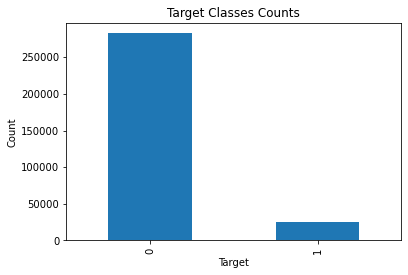

In [57]:
# visualizing TARGET counts
df['TARGET'].value_counts().plot(kind='bar');
plt.title('Target Classes Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.savefig('output/target_counts.png')

In [41]:
#correlation matrix 
#corr = numerical_df.corr()
#corr.style.background_gradient(cmap='coolwarm')
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# plt.savefig('output/correlation_matrix.png') # not sure how to save this figure

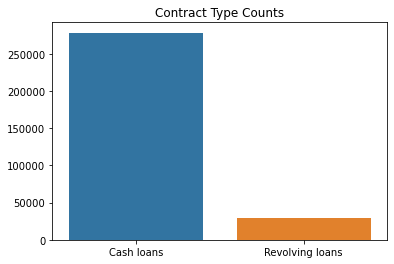

In [59]:
# count of cash loans vs revolving loans
# Revolving credit allows a borrower to spend the money they have borrowed, repay it, 
# and borrow again as needed

ax = sns.barplot(x=['Cash loans', 'Revolving loans'], y=[sum(df['NAME_CONTRACT_TYPE']=='Cash loans'), sum(df['NAME_CONTRACT_TYPE']=='Revolving loans')])
plt.title('Contract Type Counts')
plt.savefig('output/name_contract_type_counts.png')

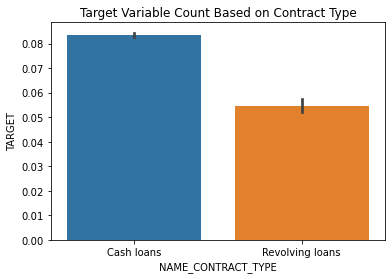

In [53]:
# how target variable varies depending on contract type - does this make sense? 

ax = sns.barplot(x="NAME_CONTRACT_TYPE", y="TARGET", data=df)
plt.title('Target Variable Count Based on Contract Type')
plt.savefig('output/target_contract_type_counts.png')

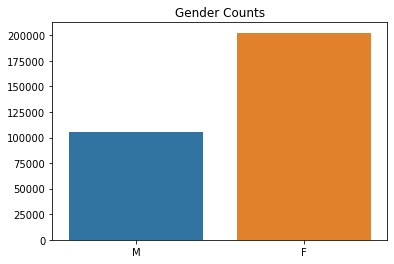

In [12]:
# Gender balance

ax = sns.barplot(x=['M', 'F'], y=[sum(df['CODE_GENDER']=='M'), sum(df['CODE_GENDER']=='F')])
plt.title('Gender Counts')
plt.savefig('output/gender_counts.png')

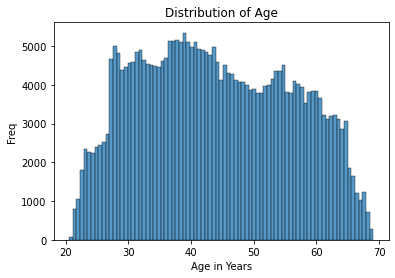

In [13]:
df['YEARS_BIRTH'] = -df['DAYS_BIRTH']/365.25

# plot the distribution of ages 

sns.histplot(data=df, x="YEARS_BIRTH")
plt.title('Distribution of Age')
plt.xlabel('Age in Years')
plt.ylabel('Freq')
plt.savefig('output/age_counts.png')

In [39]:
#for column in numerical_df.columns:
#    plt.figure(figsize=(20,5))
#    plt.subplot(121)
#    sns.distplot(df[column])
#    plt.title(column)
#    # save figure

In [40]:
#for column in categorical_df.columns:
#    plt.figure(figsize=(30,6))
#    plt.subplot(121)
#    sns.countplot(x=df[column],hue=df['TARGET'],data=df)
#    plt.title(column)    
#    plt.xticks(rotation=90)
#    # save figures

In [16]:
# Observations